# Modelling the Time Independent Schrödinger Equation

We begin with the usual expression for the TISE:
$-\frac{\hbar^2}{2m}\frac{d^2\Psi}{dx^2} + V(x)\Psi = E\Psi $

We then isolate the second derivative term:
$\frac{d^2\Psi}{dx^2} = \frac{2m}{\hbar^2}(V(x)-E)\Psi $

We wish to redefine the equation is such a way that it is unitless, for easier numerical integration.
Thus, we define the following:

| $E_0 = \frac{\hbar^2}{2ma^2}$ |                                          |
|-------------------------------|------------------------------------------|
| $\epsilon = E / E_0$          | Untiless representation of the energy    |
| $U = \frac{V(x)}{E_0}$        | Unitless representation of the potential |
| $\zeta = \frac{x}{a}$         | Unitless representation of the position  |


Our unitless expression for the second derivative is thus:  
$\Psi''(\zeta) = (U- \epsilon)\Psi(\zeta)$

For our integration algorithm  - a version of the Euler integration method - we initialize the second derivative and psi itself to zero, per the boundary condition, and the first derivative to 1 in order to generate an initially increasing wave.

The pseudo-algorithm is then:
--
Inititalize: 
$\Psi''(0) = \Psi(0) = 0$


For index in range 1 to last energy value AND small step size $\delta$ do:    
$\Psi''(index) = (U- \epsilon)\Psi(index)$  
$\Psi'(index) = \Psi'(index - 1) + \Psi''(index-1)\cdot \delta$  
$\Psi(index) = \Psi(index - 1) + \Psi'(index-1)\cdot \delta$  

Return:  
$\Psi$  

#### Import Python packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import matplotlib.cm as cm
import numpy as np
import scipy as scp
from scipy.optimize import brentq
import imageio
%matplotlib inline

In [2]:
# Set parameters for video rendering
rc('animation', html='html5')

# Setup experiment

### Declare range and step size for the energy values over which to integrate

In [3]:
x0 = 0.0; xf = 10.0; dx = 0.01

In [4]:
E0 = 0.0; Ef = 15.0

### Declare parameter dictionaries
 - params: dictionary of consants for use in numerical integration and plotting
 - psi_params: dictionary of initialization values for $\psi$, $\frac{d\psi}{dx}$, and $\frac{d^2\psi}{dx^2}$

In [6]:
params = {'x0': x0, 'xf': xf, 'dx': dx, 'a': 1, 'm': 1, 'hbar': 1}
params.update( {'nsteps': int( ( params['xf'] - params['x0'] ) / params['dx'] ) } )
params.update( {'E0':E0, 'Ef':Ef, 'dE': (Ef - E0) / params['nsteps'] } )
psi_params = {'psi_init': 0, 'd_psi_init': 1, 'd2_psi_init': 0}
params.update( {'psi_params': psi_params} )

In [7]:
e_range = np.arange(E0, Ef, params['dE'])

### Integrator Function (Team Developed)

In [8]:
def findRoot(E):
    '''
        Callable function to be passed to the SciPy root-finding algorithm.
        Args:
            - E (float): Energy value for which to search for a root
        Returns:
            - spatial (float): last value in the array corresponding to integrated psi function
    '''
    spatial = spatial_(params)
    for j in range (1, params['nsteps']):
        spatial['D2psi'][j] = (spatial['U'][j] - E) * spatial['psi'][j-1]
        spatial['Dpsi'][j] = spatial['Dpsi'][j-1] + spatial['D2psi'][j-1] * params['dx']
        spatial['psi'][j] = spatial['psi'][j-1] + spatial['Dpsi'][j-1] * params['dx']
    return spatial['psi'][-1]

In [9]:
def spatial_(params):
    '''
        Function that sets up numpy arrays that account for the various spatial constraints of the
        numerical integration task.
        Args:
            - params (dict): Dictionary defining the parameters of the numerical simulation
        Returns
            - spatial_ (dict): Dictionary of numpy arrays needed by the integration algorithm
    '''
    ## Define the unitless spatial parameters of the simulation, and the unitless potential function
    x = np.linspace(params['x0'], params['xf'], params['nsteps'])
    Z = np.zeros([params['nsteps']])
    U = np.zeros([params['nsteps']])  # = V(x)/E0
    for i in range(params['nsteps']):
        Z[i] = x[i] / params['a']
        U[i] = x[i] * (2 * params['m'] * params['a']**2) / (params['hbar']**2)
 
    ### Define arrays corresponding to second- and first-derivative, and to psi itself
    D2psi = np.zeros([params['nsteps']])
    Dpsi = np.zeros([params['nsteps']])
    psi = np.zeros([params['nsteps']])
    
    ### Initialize the values according to the boundary condition(s)
    D2psi[0] = params['psi_params']['d2_psi_init']
    Dpsi[0] = params['psi_params']['d_psi_init']
    psi[0] = params['psi_params']['psi_init']
    
    spatial_ = {'Z':Z, 'U':U, 'D2psi':D2psi, 'Dpsi':Dpsi, 'psi':psi}
    return spatial_

In [10]:
def integrator(params, D2psi, Dpsi, psi, U, Z):
    '''
        Integrator Function for generating numerical solutions to the TISE. This integration function 
        is an adaptation of the Euler method of numerical integration.
        Args:
            - params (dict): Dictionary defining the parameters of the numerical simulation
        Returns:
            - psi (list): List of NumPy arrays corresponding to computed psi functions
    '''
    for i in range(1, params['nsteps']):
        D2psi[i] = (U[i] - params['E']) * psi[i-1]
        Dpsi[i] = Dpsi[i-1] + D2psi[i-1]*params['dx']
        psi[i] = psi[i-1] + Dpsi[i-1]*params['dx']
    return psi

In [11]:
def team_tree(params, e_range):
    '''
        Integrator Function for generating numerical solutions to the TISE.
        Args:
            - params (dict): Dictionary defining the parameters of the numerical simulation
            - e_range (list or np_array): Array defining the range of energy eigenvalues
                                          over which the integrator function should run
        Returns:
            - psi (list): List of NumPy arrays corresponding to computed psi functions
    '''
    # Define a list of psi functions and a list of psi functions that have energy eigenvalues
    Psi = []; Psi_E = []
    
    # Loop over the energy range
    e_start = 1; last_root = 0.0            # Keep track of the seach range of energy values for root finding
    last_psi_pos = last_psi_neg = False     # Keep track of the tail behaviour of the psi function
    for idx, e in enumerate(e_range):
        params.update({'E': e})             # Update the energy value over which to integrate
        spatial = spatial_(params)          # Initialize the spatial constraints of the integrator
        psi = integrator(params, **spatial) # Compute psi function for specified E
        if int(e) == e_start:
            try:
                root = brentq(findRoot, int(e)-1, int(e)+1) # Attempt to find a root for this psi(e)
                if not last_root: # If no roots have been found yet, append the first one that is found
                    Psi_E.append((psi, root))
                    Psi.append((psi, root))
                    last_root = root
                # Avoid duplicates in overlapping e-ranges
                elif round(root, 3) == round(last_root, 3):                    
                    # Check the tail behaviour
                    if psi[-1] > 0: last_psi_pos = True
                    elif psi[-1] < 0: last_psi_neg = True
                    # If tail has flipped from previous iteration, record the previous psi in Psi_E
                    if last_psi_pos and last_psi_neg:
                        Psi_E[-1] = Psi[-1]
                        last_psi_pos = last_psi_neg = False # Reset for next iteration
                    Psi.append((psi, root)) # Append all psi functions for plotting
                elif round(root, 3) > round(last_root, 3):
                    Psi_E.append((psi, root)) # Append the root and corresponding psi function to Psi_E
                    Psi.append((psi, root))
                    last_root = root
            except:
                Psi.append( (psi, 0.) ) # If no root was found, append with 0.0
        elif int(e) > e_start:
            e_start += 1
        else:
            Psi.append( (psi, 0.) ) # If no root was searched for, append with 0.0
    return Psi, Psi_E

### Run the integration algorithm over the range of energy values specified in e_range array
- Here we find a sequence of psi functions corresponding to incrimental steps in the energy for plotting an animation.
- We indended to use this function to find the energy eigenvalues at the same time, but the results using these computed values give strange behaviour when plotted -- we chose a more straight-forward approach below, but left the functionality in place.

In [ ]:
Psi, Psi_E = team_tree(params, e_range)

### Find the energy eigenvalues for which $\psi$ is a valid function

#### First, we find the eigenvalues using the BrentQ root finding algorithm from the SciPy package
[BrentQ Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html)

In [12]:
eigvals = []   # Define an array of eigenvalues
params.update({'x0':0.0, 'xf':10.0, 'dx':0.01})
params.update( {'nsteps': int( ( params['xf'] - params['x0'] ) / params['dx'] ) } )
for i in range(int(Ef)):
    try:
        root = brentq(findRoot, i, i+1)
        eigvals.append(root)
    except:
        continue
print("The first {} energy eigenvalues from BrentQ are: ".format(len(eigvals)))
for i in range(len(eigvals)):
    print("{}: {}".format(str(i), str(eigvals[i])))

The first 6 energy eigenvalues from BrentQ are: 
0: 3.7147911964384774
1: 6.495996633418627
2: 8.773662715930088
3: 10.78717711562243
4: 12.62820525347683
5: 14.344105734579898


#### As a comparison, we employ our own root-finding algorithm that looks for a sign change and assumes root is in the middle

In [13]:
def signChange(numArray, dx):
    '''
        Args: An array of f(x) values, step size of x used when calculating f(x)
        Return: An array of roots where f(x) = 0
    '''
    # Find the roots given an array of numbers, return an array of the roots
    roots = []
    if numArray[0] >= 0:
        was_positive = True
    else:
        was_positive = False
    for i, n in enumerate(numArray):
        if (n >= 0):
            is_positive = True
        else:
            is_positive = False
        
        if (is_positive != was_positive):
            # Sign switch - the root is index times dx
            roots.append( i*dx - dx/2 )
        was_positive = is_positive
    return roots

In [14]:
eigeigs = [] # Array of our own eigenvalues

for i in range(params['nsteps']):
    eigeigs.append(findRoot(e_range[i]))

eigeigs = signChange(eigeigs, 0.015)

In [15]:
print("Comparison of signChange to BrentQ")
print("-"*40)
for i in range(len(eigeigs)):
    print("{} | signChange: {} \n  | BrentQ: {}".format(str(i), str(eigeigs[i]), str(eigvals[i])))
    print("-"*40)

Comparison of signChange to BrentQ
----------------------------------------
0 | signChange: 3.7125 
  | BrentQ: 3.7147911964384774
----------------------------------------
1 | signChange: 6.5024999999999995 
  | BrentQ: 6.495996633418627
----------------------------------------
2 | signChange: 8.7675 
  | BrentQ: 8.773662715930088
----------------------------------------
3 | signChange: 10.792499999999999 
  | BrentQ: 10.78717711562243
----------------------------------------
4 | signChange: 12.622499999999999 
  | BrentQ: 12.62820525347683
----------------------------------------
5 | signChange: 14.347499999999998 
  | BrentQ: 14.344105734579898
----------------------------------------


In [16]:
def plotWave(e):
    params.update({'E': e})
    spatial = spatial_(params)           # Initialize the spatial constraints of the integrator
    return integrator(params, **spatial) # Compute psi function for specified E

## Plot the computed energy eigenvalues (BrentQ) vs the energy search range

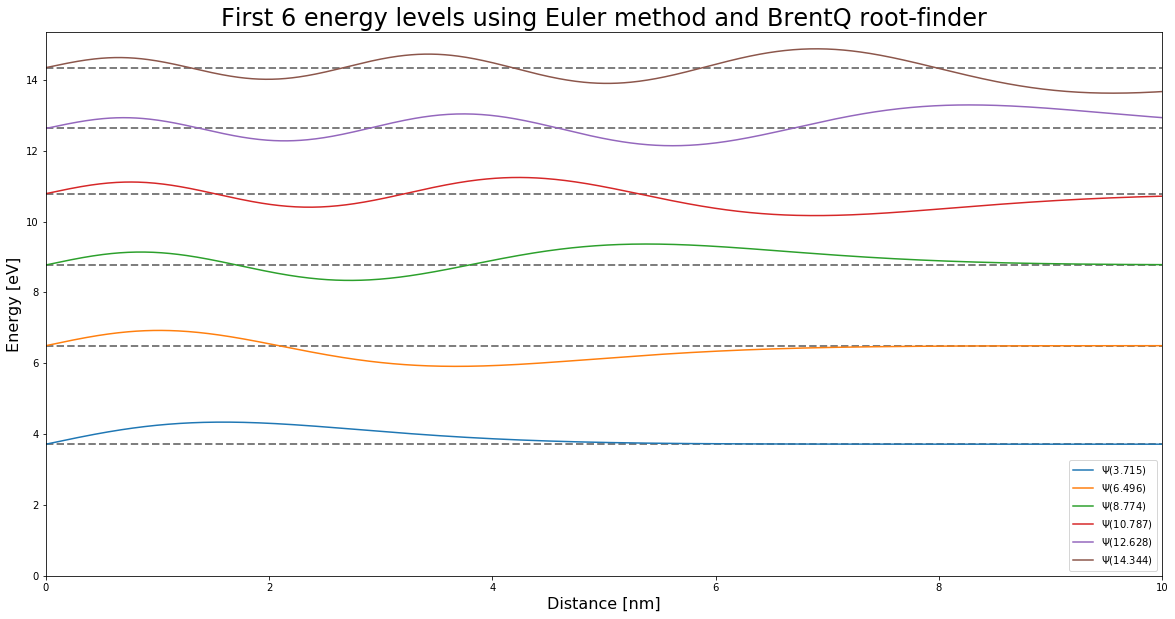

In [17]:
x = np.linspace(params['E0'], params['Ef'], params['nsteps'])

fig, ax = plt.subplots(figsize=(20,10))

# Set the axes limits
ax.set_xlim(0.0, 10.0)
ax.set_ylim(0., eigvals[-1]+1)

# Loop over list of psi functions for which an energy eigenvalue was found
for e in eigvals:
    wave = plotWave(e) + e
    ax.plot(x, wave, label='$\Psi$({})'.format(round(e, 3)))
    ax.hlines(e, 0, 10.0, lw=2, color='k', alpha=0.5, linestyle='--')

# Label the plot and save
plt.title("First {} energy levels using Euler method and BrentQ root-finder".format(len(eigvals)), fontsize=24)

plt.xlabel("Distance [nm]", fontsize=16)
plt.ylabel("Energy [eV]", fontsize=16)

# plt.plot(x, x, color='red', lw=3, alpha=0.5, linestyle='-', label = "Potential")
# plt.fill_between(x, x, alpha=0.5, color='blue', hatch='/')
# plt.fill_between(x, x, alpha=0.5, color='blue', hatch='\\')

plt.legend(loc="lower right")
plt.savefig("first_{}_energy_levels.png".format(len(eigvals)), dpi=300)

## Plot the computed energy eigenvalues (signChange) vs the energy search range

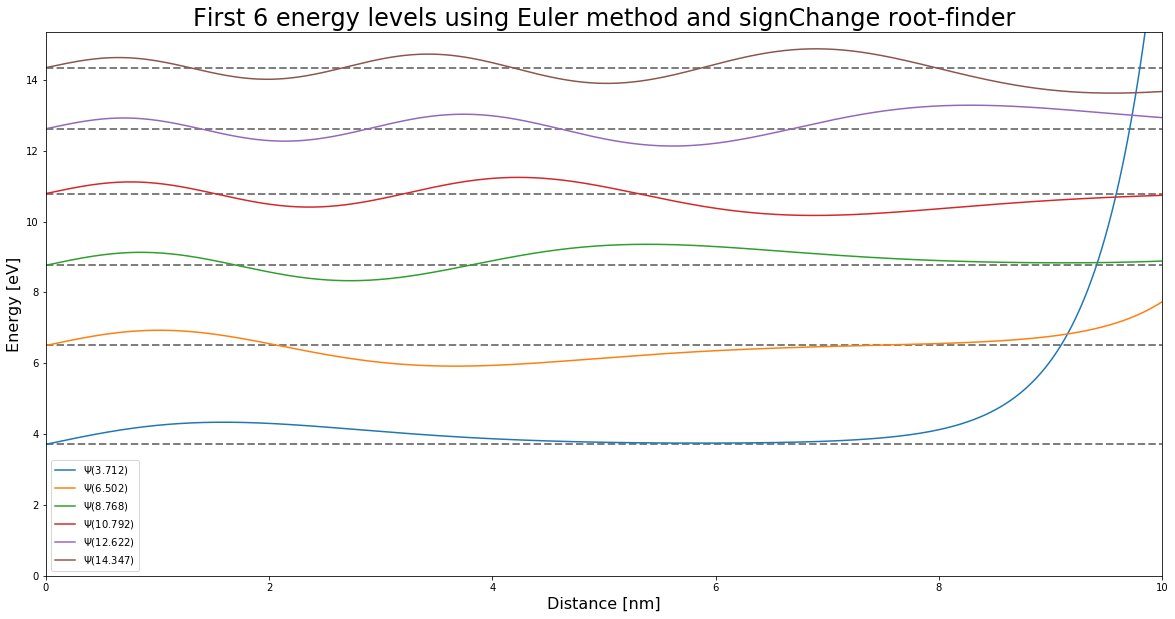

In [18]:
fig, ax = plt.subplots(figsize=(20,10))

# Set the axes limits
ax.set_xlim(params['x0'], params['xf'])
ax.set_ylim(0., eigeigs[-1]+1)
ax.set_xlim(0, 10.0)

# Loop over list of psi functions for which an energy eigenvalue was found
for e in eigeigs:
    wave = plotWave(e) + e
    ax.plot(x, wave, label='$\Psi$({})'.format(round(e, 3)))
    ax.hlines(e, 0, 10.0, lw=2, color='k', alpha=0.5, linestyle='--')

# Label the plot and save
plt.title("First {} energy levels using Euler method and signChange root-finder".format(len(eigvals)), fontsize=24)
plt.xlabel("Distance [nm]", fontsize=16)
plt.ylabel("Energy [eV]", fontsize=16)

# plt.plot(x, e_range, color='red', lw=3, alpha=0.5, linestyle='-', label = "Potential")
# plt.fill_between(x, e_range, alpha=0.5, color='blue', hatch='/')
# plt.fill_between(x, e_range, alpha=0.5, color='blue', hatch='\\')

plt.legend()
plt.savefig("first_{}_energy_levels.png".format(len(eigvals)), dpi=300)

## Wavefunction Normalization

In [23]:
def normalize(psi, params):
    '''
         This function takes the integral of psi^2 using a Riemann approximation.
         Psi is divided by the square root of this integral approximation, resulting in
         a definite integral that evaluates to 1.
         Args: 
             - psi (array) array containing the psi function to be normalized.
         returrns: 
             - psi (array) normalized values of psi(x)
    '''
    integral = 0
    for i in range(params['nsteps']):
        integral += psi[i]**2*params['dx']
        
    for i in range(params['nsteps']):
        psi[i] /= integral**(1/2)

    return psi

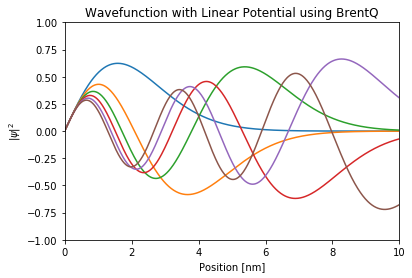

In [24]:
plt.title('Wavefunction with Linear Potential using BrentQ')
plt.xlabel('Position [nm]')
plt.ylabel('$|\psi|^2$')
plt.ylim(-1.0, 1.0)
plt.xlim(0.0, 10.0)

# params.update({'x0':0.0, 'xf':10.0, 'dx':0.01})

for e in eigvals:
    wave  = plotWave(e)
    plt.plot(x, wave)

plt.savefig('waves_brentq.png', dpi=300)

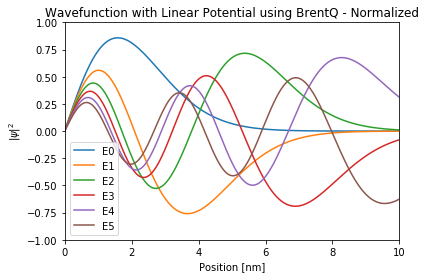

In [25]:
plt.title('Wavefunction with Linear Potential using BrentQ - Normalized')
plt.xlabel('Position [nm]')
plt.ylabel('$|\psi|^2$')
plt.ylim(-1.0, 1.0)
plt.xlim(0.0, 10.0)

for idx, e in enumerate(eigvals):
    wave  = plotWave(e)
    plt.plot(x, normalize(wave, params), label = "E{}".format(str(idx)))

plt.legend()
plt.savefig('waves_brentq-normed.png', dpi=300)

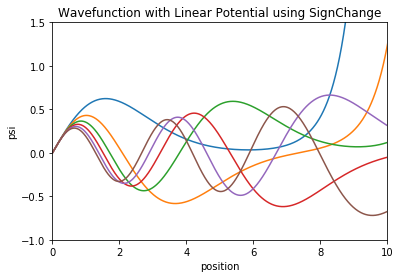

In [26]:
plt.title('Wavefunction with Linear Potential using SignChange')
plt.xlabel('position')
plt.ylabel('psi')
plt.xlim(0.0, 10.)
plt.ylim(-1, 1.5)

for e in eigeigs:
    wave = plotWave(e)
    plt.plot(x, wave)
plt.savefig("waves_signchange.png",dpi=300)

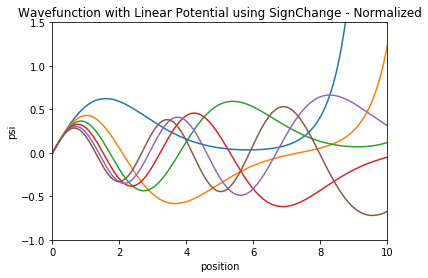

In [27]:
plt.title('Wavefunction with Linear Potential using SignChange - Normalized')
plt.xlabel('position')
plt.ylabel('psi')
plt.xlim(0.0, 10.)
plt.ylim(-1, 1.5)

for e in eigeigs:
    wave = plotWave(e)
    plt.plot(x, wave)
plt.savefig("waves_signchange-normed.png",dpi=300)

### Compute the probabilty amplitude of the wavefunctions

In [28]:
def probFunc(psi, params):
    ''' 
        This function re-normalizes psi(x) 
        This time it returns the an array of the square of normalized psi(x)
         Args: 
             - psi (array) array containing the psi function to be normalized.
         returrns: 
             - psi (array) probabilty function corresponding to psi
    '''
    integral = 0
    for i in range(params['nsteps']):
        integral += psi[i]**2*params['dx']
        
    for i in range(params['nsteps']):
        psi[i] = (psi[i] / integral**(1/2))**2
    return psi

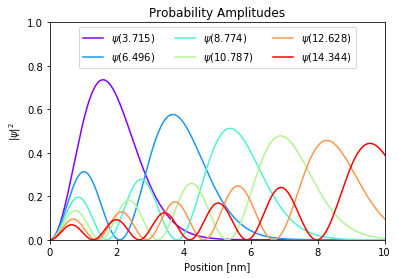

In [29]:
plt.title('Probability Amplitudes')
plt.xlabel('Position [nm]')
plt.ylabel('$|\psi|^2$')
plt.xlim(0.0, 10.0)
plt.ylim(0.0, 1.0)

colors = cm.rainbow(np.linspace(0, 1, len(eigvals)))

for idx, (e, c) in enumerate(zip(eigvals, colors)):
    wave  = plotWave(e)
    plt.plot(x, probFunc(wave, params), label = "$\psi({})$".format(round(e, 3)), color=c)

plt.legend(loc="upper center", ncol=3)
plt.savefig("prob_amps.png", dpi=300)

Lots of interesting information in this graph!! As expected, at higher energies, the particle is able to be further and further from the point of lowest potential energy. The probability of finding the particle also always goes to zero and the position goes to infinity which is good behavior. We don't expect to find the particle too far away from lowest potential energy. There is also the right number of humps for a given energy level that our experience with quantum mechanics would suggest. 

Moveover, the particle is always most likely to be in the hump furthest from zero, which is often unintuitive but actually makes sense. When the particle is at a high energy level but a low poential energy (i.e. near x = 0), it will have a much higher kinetic energy and therefore spend less time near x = 0 and more time further from 0. 

# Fun part: Plot an animation of the integration process

In [ ]:
def plot_waves(x, wave, e, idx):
    '''
        Plot Waves Function
        Args:
            - x (np_array): NumPy array defining the distance over which the 
                            corresponding wave should be plotted
            - wave (np_array): NumPy array corresponding to a computed psi function
            - e (float): energy value corresponding to the wave function
            - idx (int): index of the loop that is calling this function
        Returns:
            - image for .gif generation
    '''
    fig, ax = plt.subplots(figsize=(20,10))

    # Set axes limits
    ax.set_xlim(0.0, 10.0)
    ax.set_ylim(-1.0, e + 5.0)
    
    # Shift the wave up by its eigenvalue
    wave = wave + e     

    # Plot wave on axes object
    ax.plot(x, wave)
    ax.hlines(e, 0, e, lw=2, color='k', alpha=0.5, linestyle='--')
    
    # Plot potential on all axes obejcts
    ax.plot(x, e_range, color='orange', linestyle='-')
    ax.grid()
    
    ax.set(xlabel='Diatance [nm]', ylabel='$\Psi$_{}'.format(idx), title='$\Psi$ Animation')
    ax.legend([str(round(float(e),3))+' eV', 'Potential'])
    
    # Used to return the plot as an image array
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    
    return image

### Generate .gif from computed data

In [ ]:
waves = []
offset = 0.0
for idx, (wave, e) in enumerate(Psi):
    if e > offset:
        offset = e
    image = plot_waves(x, wave, offset, idx)
    waves.append(image)

In [ ]:
imageio.mimsave('./psi.gif', waves, fps=30.0)